This notebook presents a Seq2Seq model to generate chords giving a leadsheet.

Inspired from https://graviraja.github.io/seqtoseqimp/


In [0]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import trange
import random

In [0]:
# Optionnaly
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
os.chdir(os.path.join("drive", "My Drive", "Projet_rendu", "Seq2Seq"))
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1VcjWxh6u7uMRsQWvJEwnN-9rR9x4HIlu/Projet_rendu/Seq2Seq'

In [0]:
def data(batch_size, nb_measures=4):
    """
    DATA from make_npy_group_measures
    Load data when input is : sequences of notes belonging to n measures
    target: sequence of chords belonging to n measures
    notes : padded to 32/ measure

    Process data for torch
    For crossentropy, target must be a number (from 0 to number of classes)

    :param nb_measures: number of measures in each groups of notes
    :param batch_size:
    :return: train , validation and test dataloader
    """
    filename_test = str(nb_measures) + 'mesures.npy'
    filename_train = str(nb_measures) + 'mesures.npy'

    # nbr_groups_measures_total_in_dataset*nbr_note_each_group_measure*onehot_note
    train_inputs = np.load('Données/train_input_' + filename_train, allow_pickle=True)
    # nbr_groups_measures_total_in_dataset*nb_measure*onehot_chord
    train_targets = np.load('Données/train_target_' + filename_train, allow_pickle=True)
    test_inputs = np.load('Données/test_input_' + filename_test, allow_pickle=True)
    test_targets = np.load('Données/test_target_' + filename_test, allow_pickle=True)

    train_inputs, validation_inputs, train_targets, validation_targets = train_test_split(train_inputs, train_targets,
                                                                                          random_state=2018,
                                                                                          test_size=0.1,
                                                                                          shuffle=True)

    # Convert all of our data into torch tensors, the required datatype for our modele
    train_inputs = torch.tensor(train_inputs, dtype=torch.float)  # float
    validation_inputs = torch.tensor(validation_inputs, dtype=torch.float)
    train_targets = torch.tensor(train_targets, dtype=torch.float)  # always float!!!
    validation_targets = torch.tensor(validation_targets, dtype=torch.float)
    test_inputs = torch.tensor(test_inputs, dtype=torch.float)
    test_targets = torch.tensor(test_targets, dtype=torch.float)

    # Create an iterator of our data with torch DataLoader for memory efficency.
    train_data = TensorDataset(train_inputs, train_targets)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    validation_data = TensorDataset(validation_inputs, validation_targets)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

    test_data = TensorDataset(test_inputs, test_targets)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    return train_dataloader, validation_dataloader, test_dataloader  # TODO num workers CPU + pin_memory = True

In [0]:
def accuracy(outputs, targets):
    """
    :param outputs: (batch_size, nb_measures, 24) from model where 24 sized vector is probas (logits) for one chord
    :param targets: (batch_size) , each chord is a number meaning its class
    :return: accuracy for one batch
    """
    tot_prediction = targets.shape[0]
    # print(np.mean(outputs, axis=0))
    # print("ok")

    # log croissant donc log:softmax => valeur désirée est la plus grande (plus grande proba)
    idx_predicted = np.argmax(outputs, 1)
    return (idx_predicted == targets).sum() / tot_prediction

In [0]:
class Encodeur(nn.Module):
    # TODO add embedding layer if more feature to return dense embedding??
    """ Sequence to sequence networks consists of Encoder and Decoder modules.
    This class contains the implementation of Encoder module.
    Args:
        input_dim: A integer indicating the size of input dimension.
        emb_dim: A integer indicating the size of embeddings.
        hidden_dim: A integer indicating the hidden dimension of RNN layers.
        n_layers: A integer indicating the number of layers.
        dropout: A float indicating dropout.

    if bidirectionnal:
        - method1: we need to manually add the final states and cells for both directions
            => for each layer, SUM hidden state on backward and forward direction (and cell state)
        - method2 : half less hidden_units (128) for encoder than decoder. Concatenation of both directions for each
            layer => match hidden state shape of decoder (2 layers * batchsize * 256 hidden units)
    """

    def __init__(self, input_dim=12, hidden_dim=128, n_layers=2, dropout=0.2, bidirectional=False):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        if not bidirectional:
            self.hidden_dim *= 2  # only one direction: twice hidden units possible
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=self.hidden_dim,
                            num_layers=n_layers,
                            dropout=dropout,
                            bidirectional=bidirectional,
                            batch_first=True
                            )

    def forward(self, x):
        """
        return for last layer of lstm (on the top):
            - hidden state for all its cells (seq_len hidden states)
            - hidden cell state for all its cells
        We will need only the h_s et c_s of the last cell of the last layer, for decoder initialization


        hidden state if bidirectional: [forward_1, backward_1, forward_2, backward_2, ...]
        = for each layer for each direction the last hidden state
        => we need to sum / match dimension (two context vector for each layer, decoder need only one) for bw/fw


        method2:
        half hidden units than in the encoder to compute fowrard and backward directions and concatenate

        :param x: [batch_size, sentence_length, input_size]
        :return:
        """
        # inputs to the rnn is input, (h, c); if hidden, cell states are not passed means default initializes to zero.
        # input (with batch first): [batch_size, sequence_length, input_size]
        # hidden is of shape [num_layers * num_directions,batch_size, hidden_size]
        # cell is of shape [num_layers * num_directions,batch_size, hidden_size]
        outputs, (hidden, cell) = self.lstm(x)  # last hidden /cell (for each layer, and for each direction)

        # outputs are always from the top hidden layer, if bidirectional outputs are concatenated.
        # outputs shape [batch_size, sequence_length, hidden_dim * num_directions]
        # top hidden layer: pas derniere cellule mais derniere couche (layer number: n_layers)
        # method1
        # if self.bidirectional:
        #     # Sum backward and forward (add first dim as 0 with squeeze for concatenation of the two layers)
        #     hid_layer1 = (hidden[0, :, :] + hidden[1, :, :]).unsqueeze(0)
        #     hid_layer2 = (hidden[2, :, :] + hidden[3, :, ]).unsqueeze(0)
        #     hidden = torch.cat((hid_layer1, hid_layer2), dim=0)
        #
        #     cell_layer1 = (cell[0, :, :] + cell[1, :, :]).unsqueeze(0)
        #     cell_layer2 = (cell[2, :, :] + cell[3, :, ]).unsqueeze(0)
        #     cell = torch.cat((cell_layer1, cell_layer2), dim=0)

        # method2
        if self.bidirectional:
            # Concatenate backward and forward for each layer to match decoder hidden shape
            hid_layer1 = torch.cat((hidden[0, :, :].unsqueeze(0), hidden[1, :, :].unsqueeze(0)), dim=2)
            hid_layer2 = torch.cat((hidden[2, :, :].unsqueeze(0), hidden[3, :, :].unsqueeze(0)), dim=2)
            # concatenate both layers to match both layers of decoder
            hidden = torch.cat((hid_layer1, hid_layer2), dim=0)

            cell_layer1 = torch.cat((cell[0, :, :].unsqueeze(0), cell[1, :, :].unsqueeze(0)), dim=2)
            cell_layer2 = torch.cat((cell[2, :, :].unsqueeze(0), cell[3, :, :].unsqueeze(0)), dim=2)
            cell = torch.cat((cell_layer1, cell_layer2), dim=0)

        return hidden, cell

In [0]:
class Decoder(nn.Module):
    """ This class contains the implementation of Decoder Module.
    Args:
        output_dim: A integer indicating the size of output dimension. (onehot chord size or only one integer for its index?)
        hidden_dim: A integer indicating the hidden size of rnn.
        n_layers: A integer indicating the number of layers in rnn.
        dropout: A float indicating the dropout.
        input_dim: input dimension for the decodeur (chord one hot len)

    """

    def __init__(self, input_dim=25, output_dim=25, hidden_dim=256, n_layers=2, dropout=0.2):
        super().__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.rnn = nn.LSTM(input_size=input_dim,
                           hidden_size=hidden_dim,
                           num_layers=n_layers,
                           dropout=dropout,
                           batch_first=True,  # pas bidirectionnel ??
                           )
        self.linear = nn.Linear(hidden_dim, output_dim)

        self.activation = nn.LogSoftmax(dim=1)


    def forward(self, input, hidden, cell):
        # input is of shape [batch_size, note_len]
        # = the i-th (chords of the sequence of target/previous decoder output) for each sample
        # hidden is of shape [batch_size, n_layer * num_directions, hidden_size]
        # cell is of shape [batch_size, n_layer * num_directions, hidden_size]
        # car: deux layers dans l'encodeur => deux hidd and cell state for initialisazion of the 2 layers of decodeur
        # doit avoir meme nbr de layers pour encodeur et decodeur!

        input = input.unsqueeze(1)  # unsqueeze() inserts singleton dim at position given as parameter
        # input shape is [batch_size, output_dim]. reshape is needed rnn expects a rank 3 tensors as input.
        # so reshaping to [batch_size, 1, output_dim] means a batch of batch_size each containing 1 index.

        # embedded is of shape [1, batch_size, embedding_dim]

        output, (hidden, cell) = self.rnn(input, (hidden, cell))
        # generally output shape is [sequence_len, batch_size, hidden_dim * num_directions]
        # generally hidden shape is [num_layers * num_directions, batch_size, hidden_dim]
        # generally cell shape is [num_layers * num_directions, batch_size, hidden_dim]

        # sequence_len and num_directions will always be 1 in the decoder.
        # output shape is [batch_size, 1, hidden_dim]
        # hidden shape is [batch_size, num_layers, hidden_dim]
        # cell shape is [batch_size, num_layers, hidden_dim]

        predicted = self.linear(output.squeeze(1))  # linear expects as rank 2 tensor as input, remove
        # # predicted shape is [batch_size, output_dim]
        predicted = self.activation(predicted) #non linearity

        return predicted, hidden, cell

In [0]:
class Seq2Seq(nn.Module):  # TODO add attention
    """ This class contains the implementation of complete sequence to sequence network.
    It uses to encoder to produce the context vectors.
    It uses the decoder to produce the predicted target sentence.
    Args:
        encoder: A Encoder class instance.
        decoder: A Decoder class instance.

    Decoder : input should begin with <start> and target ends with <end> (otherwise learns identity)
    """

    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, inputs, targets, teacher_forcing_ratio=0.5):
        # we don't have embedding layer in decoder/encoder
        #   - inputs (sequence of notes) is size [batch_size, seq_len, note_len]. Others size diff also
        #   - targets is of shape [batch_size, sequence_len, chord_length]
        # if teacher_forcing_ratio is 0.5 we use ground-truth inputs 50% of time and 50% time we use decoder outputs.

        batch_size = targets.shape[0]
        max_len = targets.shape[1]  # len of the sequence of chords outputed by decoder       
        target_size = targets.shape[2]  # = self.decoder.output_dim

        # to store the outputs of the decoder
        outputs = torch.zeros(batch_size, max_len, target_size)

        # context vector, last hidden and cell state of encoder to initialize the decoder (from each layer)
        hidden, cell = self.encoder(inputs)

        # first input to the decoder is the <sos> tokens # the first chord of the seq for each sample of the batch
        input = targets[:, 0]  # size [batch_size, chord_length]

        for t in range(1, max_len):
            # pass the input, previous hidden and previous cell states into the decoder (forward)
            # receive a prediction, next hidden state and next cell state from the decoder
            output, hidden, cell = self.decoder(input, hidden, cell)
            # place our prediction / output in our tensor of predictions (output= [batch_size, chord_size])
            outputs[:, t, :] = output  # first output should be chord0
            # decide if we are going to “teacher force” or not
            use_teacher_force = random.random() < teacher_forcing_ratio
            # torch.max = max values, indices
            # target: batch_size*chord_size => 1 chord target for each sample
            input = (targets[:, t, :] if use_teacher_force else output)
            # last output=model(lastchord) => target <end> = last target

        # outputs is of shape [batch_size, sequence_len, output_dim]
        return outputs


In [0]:
def train(model, train_dataloader, validation_dataloader, learning_rate=0.001, eps=1e-8, epochs=400, patience=15, model_name="Normal"):
    """
    target: must be a single number, not a one hot... for using cross_entropy
    :param patience: break if no improvment of validation accuracy after waiting 10 epochs
    :return:
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    best_loss = 100
    best_model = None

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=eps)
    # PyTorch scheduler: reduce lr by factor after patience with no improvment of val_loss (mieux que StepLR)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=False, threshold=0.0001,
                                  threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
    # criterion = nn.CrossEntropyLoss()  # Because classification pb (if regression, MSE). = nn.logsoftmax + nn.NLLLoss
    criterion = nn.NLLLoss()  # si nn.logsoftmax dans le modele (pour le test)

    max_grad_norm = 10.0  # Gradient threshold, gradients norms that exceed this threshold are scaled down to match
    # the norm.

    # Tracking values
    val_accuracies = list()
    val_losses = list()
    train_accuracies = list()
    train_losses = list()

    p = 0  # patience

    model.cuda()
    for epoch in trange(epochs, desc="Epoch"):
        if p >= patience:
            break

        model.zero_grad()  # Clear stored gradient
        model.train()  # training mode

        # Tracking variables
        tr_loss, tr_acc, nb_tr_steps = 0, 0, 0

        # Train on all our data for one epoch
        for step, batch in enumerate(train_dataloader):
            # Add batch to GPU
            b_inputs, b_targets = tuple(t.to(device) for t in batch)

            # Forward pass
            # output is of shape [batch_size, sequence_len, output_dim] = 1024*4*24
            outputs = model(b_inputs, b_targets)

            # with tokens start and end, doesn't compute loss for input(start)<=>output(chord0)
            # compute loss for chord0, => last chord, <end>
            outputs = outputs[:, 1:, :]
            b_targets = b_targets[:, 1:, :]  # ignore start token
            b_targets = b_targets.max(2)[1]  # max return (values of max, indices)
            b_targets = b_targets.view(-1).to(device)
            outputs = outputs.reshape(-1, outputs.shape[2]).to(device)
            loss = criterion(outputs, b_targets)  # -1: torch chose. view: reshape tensor

            # Backward pass
            loss.backward()

            # Update tracking variables
            tr_loss += loss.item()

            # Move logits and labels to CPU
            outputs = outputs.detach().cpu().numpy()
            b_targets = b_targets.to('cpu').numpy()
            tr_acc += accuracy(outputs, b_targets)

            # AdamW optimizer: update parameters and take a step using the computed gradient
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()  # Perform a step of gradient descent
            model.zero_grad()  # Reset gradient

            nb_tr_steps += 1
            # if nb_tr_steps % 50 == 0:
            #     print("Step {} out  of {} /n".format(nb_tr_steps, (num_training_steps // epochs)))

        train_accuracy = tr_acc / nb_tr_steps
        train_loss = tr_loss / nb_tr_steps
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)


        # 2. Validation step
        # Put model in evaluation mode to evaluate loss on the validation set
        model.eval()

        # Tracking variables
        nb_eval_steps, v_acc, v_loss = 0, 0, 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            # Add batch to GPU, Unpack the inputs from our dataloader
            b_inputs, b_targets = tuple(t.to(device) for t in batch)
            # Telling the model not to compute or store gradients, saving memory and speeding up validation
            with torch.no_grad():
                # Forward pass, calculate logit predictions
                # turn off the teacher forcing
                outputs = model(b_inputs, b_targets, 0)

            # with tokens start and end, doesn't compute loss for input(start)<=>output(chord0)
            # compute loss for chord0, => last chord, <end>
            outputs = outputs[:, 1:, :]
            b_targets = b_targets[:, 1:, :]  # ignore start token
            b_targets = b_targets.max(2)[1]  # max return (values of max, indices)
            b_targets = b_targets.view(-1).to(device)
            outputs = outputs.reshape(-1, outputs.shape[2]).to(device)
            loss = criterion(outputs, b_targets)  # -1: torch chose. view: reshape tensor

            v_loss += criterion(outputs, b_targets).item()

            # Move logits and labels to CPU
            outputs = outputs.detach().cpu().numpy()
            b_targets = b_targets.to('cpu').numpy()
            v_acc += accuracy(outputs, b_targets)

            nb_eval_steps += 1
        val_accuracy = v_acc / nb_eval_steps
        val_loss = v_loss/nb_eval_steps
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)

        # avoid overfitting
        if val_loss < best_loss:
            p = 0
            best_model = model
            best_loss = val_loss
            torch.save(best_model.state_dict(), os.path.join(os.getcwd(), "Modèles entraînés", "Seq2Seq_" + model_name))
        else:
            p += 1

        print("Train loss: {} - Train accuracy: {} -  Val loss: {} - Val accuracy: {}".format(train_loss, train_accuracy
                                                                                              , val_loss, val_accuracy))

        scheduler.step(val_loss)

    return best_model, train_losses, train_accuracies, val_accuracies, val_losses


In [0]:
chord_dictionary = ['C:maj', 'C:min',
                    'C#:maj', 'C#:min',
                    'D:maj', 'D:min',
                    'D#:maj', 'D#:min',
                    'E:maj', 'E:min',
                    'F:maj', 'F:min',
                    'F#:maj', 'F#:min',
                    'G:maj', 'G:min',
                    'G#:maj', 'G#:min',
                    'A:maj', 'A:min',
                    'A#:maj', 'A#:min',
                    'B:maj', 'B:min']


def test(model, test_dataloader, show_results=False):  # TODO sortir ouput pour une chanson avec index chanson
    """
    Test model on test songs
    :param mode: type of vector/feature to keep
    :param batch_size:
    :param model:
    :return:
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    test_acc = 0
    nb_tr_steps = 0
    with torch.no_grad():
        for step, batch in enumerate(test_dataloader):
            # Add batch to GPU
            b_inputs, b_targets = tuple(t.to(device) for t in batch)
            # No teacher forcing ############# but target[0] is used as firsst input decoder !! should be <start>
            outputs = model(b_inputs, b_targets, 0)

            # with tokens start and end, doesn't compute loss for input(start)<=>output(chord0)
            # compute loss for chord0, => last chord, <end>
            outputs = outputs[:, 1:, :]
            b_targets = b_targets[:, 1:, :]  # ignore start token
            b_targets = b_targets.max(2)[1]  # max return (values of max, indices)
            b_targets = b_targets.view(-1).to(device)
            outputs = outputs.reshape(-1, outputs.shape[2]).to(device)

            outputs = outputs.detach().cpu().numpy()
            b_targets = b_targets.to('cpu').numpy()

            if show_results:
              chords = np.argmax(outputs, 1)
              print([chord_dictionary[chord] for chord in chords])

            test_acc += accuracy(outputs, b_targets)
            nb_tr_steps += 1
        test_accuracy = test_acc / nb_tr_steps
    print("Test accuracy: {}".format(test_accuracy))
    pass

In [0]:
def show_result(train_losses, train_accuracies, val_accuracies, val_losses):
    plt.plot(np.arange(len(val_accuracies)), train_losses, label='train loss')
    plt.plot(np.arange(len(val_accuracies)), val_losses, label='val loss')
    plt.legend(loc="upper right")
    plt.title("Negative log-likelihood val-train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(np.arange(len(val_accuracies)), val_accuracies, label='val accuracy')
    plt.plot(np.arange(len(val_accuracies)), train_accuracies, label='train accuracy')
    plt.legend()
    plt.title("Accuracy over validation/train-set")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()
    pass

In [0]:
train_dataloader, validation_dataloader, test_dataloader = data(batch_size=2048, nb_measures=4)

In [0]:
  encoder = Encodeur(input_dim=12, bidirectional=False)
  decoder = Decoder()
  model = Seq2Seq(encoder, decoder)
  best_model, train_losses, train_accuracies, val_accuracies, val_losses = train(model, 
                                                                                 train_dataloader, 
                                                                                 validation_dataloader, 
                                                                                 model_name="TEST.pth", 
                                                                                 learning_rate=0.001)
  print("DONE")

Epoch:   0%|          | 1/400 [00:17<1:59:06, 17.91s/it]

Train loss: 2.48338052204677 - Train accuracy: 0.2742785537800216 -  Val loss: 2.276746451854706 - Val accuracy: 0.2939303311434659


Epoch:   0%|          | 2/400 [00:35<1:58:45, 17.90s/it]

Train loss: 2.2645662937845503 - Train accuracy: 0.29438058106280257 -  Val loss: 2.2674182653427124 - Val accuracy: 0.2939303311434659


Epoch:   1%|          | 3/400 [00:53<1:58:42, 17.94s/it]

Train loss: 2.2619197198322842 - Train accuracy: 0.294402813754663 -  Val loss: 2.2658552527427673 - Val accuracy: 0.2939303311434659


Epoch:   1%|          | 4/400 [01:11<1:58:22, 17.94s/it]

Train loss: 2.260922576699938 - Train accuracy: 0.29438183360882286 -  Val loss: 2.26477587223053 - Val accuracy: 0.2939303311434659


Epoch:   1%|▏         | 5/400 [01:30<1:58:59, 18.08s/it]

Train loss: 2.2482552187783376 - Train accuracy: 0.2962040609341411 -  Val loss: 2.2435832023620605 - Val accuracy: 0.2996115944602273


Epoch:   2%|▏         | 6/400 [01:48<1:59:02, 18.13s/it]

Train loss: 2.23853462934494 - Train accuracy: 0.29769435253814513 -  Val loss: 2.2289119362831116 - Val accuracy: 0.3034756747159091


Epoch:   2%|▏         | 7/400 [02:06<1:59:26, 18.24s/it]

Train loss: 2.224155162061964 - Train accuracy: 0.2996815719290253 -  Val loss: 2.2144343852996826 - Val accuracy: 0.29255260120738635


Epoch:   2%|▏         | 8/400 [02:25<1:59:30, 18.29s/it]

Train loss: 2.201112278870174 - Train accuracy: 0.2972981179843309 -  Val loss: 2.195301353931427 - Val accuracy: 0.3041986638849432


Epoch:   2%|▏         | 9/400 [02:44<2:00:15, 18.45s/it]

Train loss: 2.18189799785614 - Train accuracy: 0.30632837056958595 -  Val loss: 2.1853861212730408 - Val accuracy: 0.31097856001420454


Epoch:   2%|▎         | 10/400 [03:02<2:00:11, 18.49s/it]

Train loss: 2.1600092904908315 - Train accuracy: 0.31374311884735284 -  Val loss: 2.1797950863838196 - Val accuracy: 0.30675992098721594


Epoch:   3%|▎         | 11/400 [03:21<2:00:09, 18.53s/it]

Train loss: 2.1471304638045177 - Train accuracy: 0.31947245178509326 -  Val loss: 2.1800875067710876 - Val accuracy: 0.3074102228338068


Epoch:   3%|▎         | 12/400 [03:39<1:59:50, 18.53s/it]

Train loss: 2.2206518820353915 - Train accuracy: 0.30297449556972705 -  Val loss: 2.2584874629974365 - Val accuracy: 0.2939303311434659


Epoch:   3%|▎         | 13/400 [03:58<1:59:13, 18.48s/it]

Train loss: 2.202896467276982 - Train accuracy: 0.30973156236380767 -  Val loss: 2.26583468914032 - Val accuracy: 0.2939303311434659


Epoch:   4%|▎         | 14/400 [04:16<1:59:14, 18.53s/it]

Train loss: 2.174691046987261 - Train accuracy: 0.3172847963635378 -  Val loss: 2.2009658217430115 - Val accuracy: 0.2944280450994318


Epoch:   4%|▍         | 15/400 [04:35<1:58:58, 18.54s/it]

Train loss: 2.148334034851619 - Train accuracy: 0.3203466230583067 -  Val loss: 2.1566028594970703 - Val accuracy: 0.31308205344460227


Epoch:   4%|▍         | 16/400 [04:54<1:58:39, 18.54s/it]

Train loss: 2.076359902109419 - Train accuracy: 0.34726380175167326 -  Val loss: 2.0903990268707275 - Val accuracy: 0.33661942915482956


Epoch:   4%|▍         | 17/400 [05:12<1:58:16, 18.53s/it]

Train loss: 2.042112269571849 - Train accuracy: 0.3591908514779619 -  Val loss: 2.0632320046424866 - Val accuracy: 0.34541570490056817


Epoch:   4%|▍         | 18/400 [05:31<1:58:10, 18.56s/it]

Train loss: 2.010737189224788 - Train accuracy: 0.36874743139858374 -  Val loss: 2.0509555339813232 - Val accuracy: 0.350958251953125


Epoch:   5%|▍         | 19/400 [05:49<1:57:45, 18.54s/it]

Train loss: 1.982821375131607 - Train accuracy: 0.37865882585207 -  Val loss: 2.126179575920105 - Val accuracy: 0.29924760298295455


Epoch:   5%|▌         | 20/400 [06:08<1:57:39, 18.58s/it]

Train loss: 2.000218838453293 - Train accuracy: 0.3683047953071652 -  Val loss: 2.024160385131836 - Val accuracy: 0.3598627263849432


Epoch:   5%|▌         | 21/400 [06:27<1:57:37, 18.62s/it]

Train loss: 1.9410348875182015 - Train accuracy: 0.3944782306972426 -  Val loss: 1.9611576795578003 - Val accuracy: 0.3879566539417614


Epoch:   6%|▌         | 22/400 [06:45<1:57:15, 18.61s/it]

Train loss: 1.9032133987971716 - Train accuracy: 0.4111360607399435 -  Val loss: 1.9630869328975677 - Val accuracy: 0.38665327592329546


Epoch:   6%|▌         | 23/400 [07:04<1:56:48, 18.59s/it]

Train loss: 1.880908421107701 - Train accuracy: 0.41848525763919 -  Val loss: 1.9152500927448273 - Val accuracy: 0.4064109108664773


Epoch:   6%|▌         | 24/400 [07:22<1:56:36, 18.61s/it]

Train loss: 1.8439394533634186 - Train accuracy: 0.43027536306898756 -  Val loss: 1.8897679448127747 - Val accuracy: 0.4148198908025568


Epoch:   6%|▋         | 25/400 [07:41<1:56:20, 18.61s/it]

Train loss: 1.8168660146849496 - Train accuracy: 0.44066049336129437 -  Val loss: 1.8578844964504242 - Val accuracy: 0.42664018110795454


Epoch:   6%|▋         | 26/400 [08:00<1:56:12, 18.64s/it]

Train loss: 1.7999018728733063 - Train accuracy: 0.4448773152342903 -  Val loss: 1.8444664478302002 - Val accuracy: 0.4332347523082386


Epoch:   7%|▋         | 27/400 [08:18<1:55:41, 18.61s/it]

Train loss: 1.790951200893947 - Train accuracy: 0.4486693961055769 -  Val loss: 1.8358653485774994 - Val accuracy: 0.434295654296875


Epoch:   7%|▋         | 28/400 [08:37<1:55:46, 18.67s/it]

Train loss: 1.7794362136295863 - Train accuracy: 0.45106117242470894 -  Val loss: 1.8045534789562225 - Val accuracy: 0.4438853870738636


Epoch:   7%|▋         | 29/400 [08:56<1:55:19, 18.65s/it]

Train loss: 1.7317864171096258 - Train accuracy: 0.4665717254424769 -  Val loss: 1.8000623881816864 - Val accuracy: 0.44274402965198867


Epoch:   8%|▊         | 30/400 [09:14<1:54:57, 18.64s/it]

Train loss: 1.7122948510306222 - Train accuracy: 0.47212440749280793 -  Val loss: 1.7653233706951141 - Val accuracy: 0.4557900168678977


Epoch:   8%|▊         | 31/400 [09:33<1:54:42, 18.65s/it]

Train loss: 1.6872179976531438 - Train accuracy: 0.4797149753026151 -  Val loss: 1.7561449110507965 - Val accuracy: 0.456829833984375


Epoch:   8%|▊         | 32/400 [09:52<1:54:20, 18.64s/it]

Train loss: 1.6682775999818529 - Train accuracy: 0.48430452223449133 -  Val loss: 1.742406815290451 - Val accuracy: 0.4620838512073864


Epoch:   8%|▊         | 33/400 [10:10<1:53:56, 18.63s/it]

Train loss: 1.6558860114642553 - Train accuracy: 0.4865749735942129 -  Val loss: 1.7286305725574493 - Val accuracy: 0.46416847922585225


Epoch:   8%|▊         | 34/400 [10:29<1:53:39, 18.63s/it]

Train loss: 1.6344463867800576 - Train accuracy: 0.4936191645115819 -  Val loss: 1.7176562249660492 - Val accuracy: 0.46918778852982956


Epoch:   9%|▉         | 35/400 [10:47<1:53:13, 18.61s/it]

Train loss: 1.6135244837829046 - Train accuracy: 0.49885371089868874 -  Val loss: 1.703849345445633 - Val accuracy: 0.47460160688920455


Epoch:   9%|▉         | 36/400 [11:06<1:53:07, 18.65s/it]

Train loss: 1.616144401686532 - Train accuracy: 0.4967881390207532 -  Val loss: 1.7010499835014343 - Val accuracy: 0.47380315607244317


Epoch:   9%|▉         | 37/400 [11:25<1:52:56, 18.67s/it]

Train loss: 1.5740543816770827 - Train accuracy: 0.5100495935011844 -  Val loss: 1.6833958625793457 - Val accuracy: 0.47596990411931817


Epoch:  10%|▉         | 38/400 [11:43<1:52:38, 18.67s/it]

Train loss: 1.5794465754713332 - Train accuracy: 0.5076679081161878 -  Val loss: 1.6824171841144562 - Val accuracy: 0.47529851740056817


Epoch:  10%|▉         | 39/400 [12:02<1:52:21, 18.67s/it]

Train loss: 1.5620085171290807 - Train accuracy: 0.5123620404355728 -  Val loss: 1.667559653520584 - Val accuracy: 0.4817754572088068


Epoch:  10%|█         | 40/400 [12:21<1:52:13, 18.71s/it]

Train loss: 1.5312259878431047 - Train accuracy: 0.5217653687043862 -  Val loss: 1.6561796963214874 - Val accuracy: 0.48666825727982954


Epoch:  10%|█         | 41/400 [12:40<1:52:07, 18.74s/it]

Train loss: 1.5177816791193826 - Train accuracy: 0.5255632778840031 -  Val loss: 1.6523506045341492 - Val accuracy: 0.4855341131036932


Epoch:  10%|█         | 42/400 [12:58<1:51:25, 18.68s/it]

Train loss: 1.5102563841002328 - Train accuracy: 0.5270824000983407 -  Val loss: 1.6571112275123596 - Val accuracy: 0.48577381480823867


Epoch:  11%|█         | 43/400 [13:17<1:51:19, 18.71s/it]

Train loss: 1.5038178392818995 - Train accuracy: 0.5284247655763095 -  Val loss: 1.6392033696174622 - Val accuracy: 0.49135409268465907


Epoch:  11%|█         | 44/400 [13:36<1:50:59, 18.71s/it]

Train loss: 1.4776286610535212 - Train accuracy: 0.5370397065379938 -  Val loss: 1.6353958249092102 - Val accuracy: 0.49328391335227273


Epoch:  11%|█▏        | 45/400 [13:54<1:50:39, 18.70s/it]

Train loss: 1.4792129227093287 - Train accuracy: 0.5351739422125368 -  Val loss: 1.629263550043106 - Val accuracy: 0.4918445933948864


Epoch:  12%|█▏        | 46/400 [14:13<1:49:56, 18.63s/it]

Train loss: 1.4708859154156275 - Train accuracy: 0.5382442963641024 -  Val loss: 1.6221681833267212 - Val accuracy: 0.49655650745738633


Epoch:  12%|█▏        | 47/400 [14:31<1:49:33, 18.62s/it]

Train loss: 1.4342101684638433 - Train accuracy: 0.5487630940455303 -  Val loss: 1.6194995045661926 - Val accuracy: 0.49471546519886367


Epoch:  12%|█▏        | 48/400 [14:50<1:49:09, 18.61s/it]

Train loss: 1.4186754993030004 - Train accuracy: 0.5541389796661326 -  Val loss: 1.6293845176696777 - Val accuracy: 0.4913651899857955


Epoch:  12%|█▏        | 49/400 [15:09<1:49:05, 18.65s/it]

Train loss: 1.4046246111392975 - Train accuracy: 0.5575447868117277 -  Val loss: 1.6132134199142456 - Val accuracy: 0.5013666326349432


Epoch:  12%|█▎        | 50/400 [15:27<1:48:41, 18.63s/it]

Train loss: 1.3808723475251878 - Train accuracy: 0.5651044864187317 -  Val loss: 1.6050220727920532 - Val accuracy: 0.5049915660511364


Epoch:  13%|█▎        | 51/400 [15:46<1:48:26, 18.64s/it]

Train loss: 1.3673853320734841 - Train accuracy: 0.5687746292887176 -  Val loss: 1.606783151626587 - Val accuracy: 0.5030284534801136


Epoch:  13%|█▎        | 52/400 [16:05<1:48:06, 18.64s/it]

Train loss: 1.348226466349193 - Train accuracy: 0.5744857517950572 -  Val loss: 1.6081126034259796 - Val accuracy: 0.5019320401278409


Epoch:  13%|█▎        | 53/400 [16:23<1:47:55, 18.66s/it]

Train loss: 1.3394200674125127 - Train accuracy: 0.578601254161981 -  Val loss: 1.605454921722412 - Val accuracy: 0.5044888583096591


Epoch:  14%|█▎        | 54/400 [16:42<1:47:30, 18.64s/it]

Train loss: 1.301257576261248 - Train accuracy: 0.5896409455988568 -  Val loss: 1.6052979528903961 - Val accuracy: 0.5080571954900568


Epoch:  14%|█▍        | 55/400 [17:01<1:47:02, 18.62s/it]

Train loss: 1.3021642693451472 - Train accuracy: 0.5889515667621847 -  Val loss: 1.6115533709526062 - Val accuracy: 0.5083440607244318


Epoch:  14%|█▍        | 56/400 [17:19<1:46:49, 18.63s/it]

Train loss: 1.265782811811992 - Train accuracy: 0.5999111349471207 -  Val loss: 1.595795750617981 - Val accuracy: 0.515658846768466


Epoch:  14%|█▍        | 57/400 [17:38<1:46:40, 18.66s/it]

Train loss: 1.2520079059260232 - Train accuracy: 0.6042226651765956 -  Val loss: 1.6162923276424408 - Val accuracy: 0.5093272816051136


Epoch:  14%|█▍        | 58/400 [17:57<1:46:21, 18.66s/it]

Train loss: 1.2335924676486425 - Train accuracy: 0.6103973686372074 -  Val loss: 1.6010362207889557 - Val accuracy: 0.5119895241477272


Epoch:  15%|█▍        | 59/400 [18:15<1:45:57, 18.64s/it]

Train loss: 1.210187703371048 - Train accuracy: 0.6186095829755639 -  Val loss: 1.6006420850753784 - Val accuracy: 0.5190302068536932


Epoch:  15%|█▌        | 60/400 [18:34<1:45:43, 18.66s/it]

Train loss: 1.1965370603970118 - Train accuracy: 0.6211020282707046 -  Val loss: 1.5995824038982391 - Val accuracy: 0.5203030672940341


Epoch:  15%|█▌        | 61/400 [18:53<1:45:26, 18.66s/it]

Train loss: 1.1765664773327964 - Train accuracy: 0.6286047304182247 -  Val loss: 1.6132998168468475 - Val accuracy: 0.5153348055752841


Epoch:  16%|█▌        | 62/400 [19:11<1:44:50, 18.61s/it]

Train loss: 1.1490175127983093 - Train accuracy: 0.6374649675227166 -  Val loss: 1.6253063380718231 - Val accuracy: 0.5093228426846591


Epoch:  16%|█▌        | 63/400 [19:30<1:44:46, 18.65s/it]

Train loss: 1.0930925948279244 - Train accuracy: 0.6569147094135573 -  Val loss: 1.5809186398983002 - Val accuracy: 0.52794189453125


Epoch:  16%|█▌        | 64/400 [19:49<1:44:33, 18.67s/it]

Train loss: 1.0605044194630213 - Train accuracy: 0.6674705652567303 -  Val loss: 1.5836074948310852 - Val accuracy: 0.5260658957741478


Epoch:  16%|█▋        | 65/400 [20:07<1:44:10, 18.66s/it]

Train loss: 1.0572526071752821 - Train accuracy: 0.6688390754276863 -  Val loss: 1.5836312174797058 - Val accuracy: 0.529010009765625


Epoch:  16%|█▋        | 66/400 [20:26<1:43:53, 18.66s/it]

Train loss: 1.0464475069727217 - Train accuracy: 0.6734934636679798 -  Val loss: 1.5868408381938934 - Val accuracy: 0.528155517578125


Epoch:  17%|█▋        | 67/400 [20:45<1:43:43, 18.69s/it]

Train loss: 1.0437900147267751 - Train accuracy: 0.6735099628745359 -  Val loss: 1.5901341438293457 - Val accuracy: 0.5258522727272728


Epoch:  17%|█▋        | 68/400 [21:03<1:43:28, 18.70s/it]

Train loss: 1.0359072663954325 - Train accuracy: 0.6767708517686938 -  Val loss: 1.5922236442565918 - Val accuracy: 0.5282964533025568


Epoch:  17%|█▋        | 69/400 [21:22<1:43:09, 18.70s/it]

Train loss: 1.0351312777825765 - Train accuracy: 0.677400761131641 -  Val loss: 1.593057781457901 - Val accuracy: 0.5268549138849432


Epoch:  18%|█▊        | 70/400 [21:41<1:43:02, 18.73s/it]

Train loss: 1.028699231999261 - Train accuracy: 0.6792020700563456 -  Val loss: 1.5904821157455444 - Val accuracy: 0.5278619939630682


Epoch:  18%|█▊        | 71/400 [22:00<1:42:45, 18.74s/it]

Train loss: 1.028037660888263 - Train accuracy: 0.6795805043434768 -  Val loss: 1.5904010832309723 - Val accuracy: 0.5288080388849432


Epoch:  18%|█▊        | 72/400 [22:18<1:42:27, 18.74s/it]

Train loss: 1.0230576332126344 - Train accuracy: 0.6812496983304656 -  Val loss: 1.5900566577911377 - Val accuracy: 0.5282187721946023


Epoch:  18%|█▊        | 73/400 [22:37<1:42:06, 18.74s/it]

Train loss: 1.0201379039457865 - Train accuracy: 0.681995404249878 -  Val loss: 1.5902787148952484 - Val accuracy: 0.5290521795099432


Epoch:  18%|█▊        | 74/400 [22:56<1:41:27, 18.67s/it]

Train loss: 1.0273089089563914 - Train accuracy: 0.6804615161056954 -  Val loss: 1.5904790163040161 - Val accuracy: 0.5288596413352273


Epoch:  19%|█▉        | 75/400 [23:14<1:41:22, 18.71s/it]

Train loss: 1.0194661510842187 - Train accuracy: 0.6812199150794969 -  Val loss: 1.5910038948059082 - Val accuracy: 0.5279441139914773


Epoch:  19%|█▉        | 76/400 [23:33<1:40:54, 18.69s/it]

Train loss: 1.0191578716039658 - Train accuracy: 0.6820146003997138 -  Val loss: 1.591061919927597 - Val accuracy: 0.5278830788352273


Epoch:  19%|█▉        | 77/400 [23:52<1:40:38, 18.70s/it]

Train loss: 1.019843829529626 - Train accuracy: 0.6816074788393818 -  Val loss: 1.5909864902496338 - Val accuracy: 0.5275379527698864


Epoch:  20%|█▉        | 78/400 [24:11<1:40:29, 18.73s/it]

Train loss: 1.023205993430955 - Train accuracy: 0.6811701285803764 -  Val loss: 1.590893030166626 - Val accuracy: 0.5275379527698864
DONE


In [0]:
encoder = Encodeur(input_dim=12, bidirectional=False)
decoder = Decoder()
model_trained = Seq2Seq(encoder, decoder)
model_trained.load_state_dict(torch.
load(os.path.join(os.getcwd(), "Modèles entraînés", "Seq2Seq_UniDir_4mesures.pth")))
test(model_trained, test_dataloader, show_results=False)

Test accuracy: 0.47144099239079923


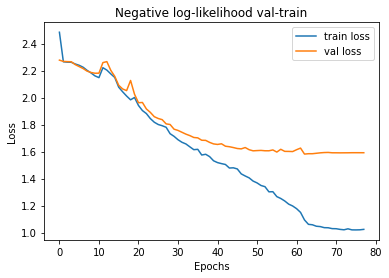

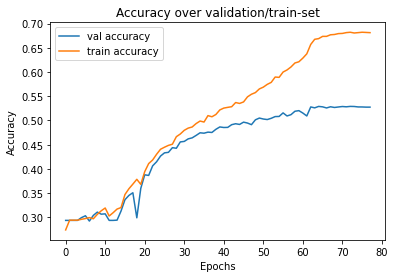

In [0]:
show_result(train_losses, train_accuracies, val_accuracies, val_losses)